Repressilator simulated as detailed in the Material and Methods section of the Niederholtmayer/Maerkl paper.

Adaptable for n nodes with varying parameters.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint

$g_i$: Genes

$r_i$: mRNAs

$p_i$: Proteins

$$ \dot r_i = -(a_i + \mu) r_i + \beta_i g_i \frac{K_{i-1}^{\nu_i}}{K_{i-1}^{\nu_i} + p_{i-1}^{\nu_i}} $$

$$ \dot p_i = -(b_i + \mu) p_i + c_i r_i $$

In [78]:
# ODE system

def repressilator(y, t, a, b, beta, c, K, nu, g, mu):
    n = len(y)/2
    r = np.array(y[0:n])
    p = np.array(y[n:2*n])
    p_shift = np.roll(p,1) # p_{i-1}
    
    drdt = -(a + mu)*r + beta*g/(1+np.power(p_shift/np.roll(K,1),nu))
    dpdt = -(b + mu)*p + c*r
    return np.append(drdt,dpdt)

In [79]:
# Parameters

# From Materials and Methods / Model
# Identical parameters for now, asyymetry possible

# Degradation rate of mRNAs (1/min) 
a = np.array([np.log(2)/8.,np.log(2)/8.,np.log(2)/8.]) # --> half life 8 min
# Degradatoin rate of proteins (1/min)
b = np.array([np.log(2)/90.,np.log(2)/90.,np.log(2)/90.]) # --> half life 90 min
# Transcription rate
beta = 0.4
# Translation rate
c = np.array([0.5,0.5,0.5])
# Michaelis Menten constant
K = np.array([5,5,5])
# Hill coefficient
nu = np.array([2,2,2])
# Circuit plasmid concentration
g = np.array([5.0])
# Dilution rate
T_d = 27. # --> doubling time
mu = np.log(2)/T_d 

In [80]:
# Initial conditions

r0 = np.array([30,0,0])
p0 = np.array([0,0,0])
y0 = np.append(r0,p0)

In [81]:
# Run

t = np.linspace(0,30*60,1001) # simulate 30h
y = odeint(repressilator, y0, t, args=(a, b, beta, c, K, nu, g, mu))

C:\Users\Joaquin\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Joaquin\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


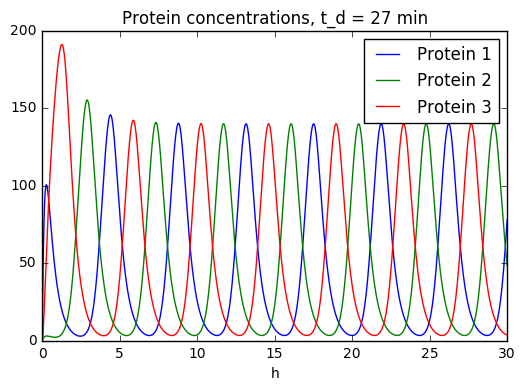

In [82]:
plt.figure()
plt.plot(t/60,y[:,3], label='Protein 1')
plt.plot(t/60,y[:,4], label='Protein 2')
plt.plot(t/60,y[:,5], label='Protein 3')
plt.xlabel('h')
title = 'Protein concentrations, t_d = %i min' % T_d
plt.title(title)
plt.legend()
plt.show()

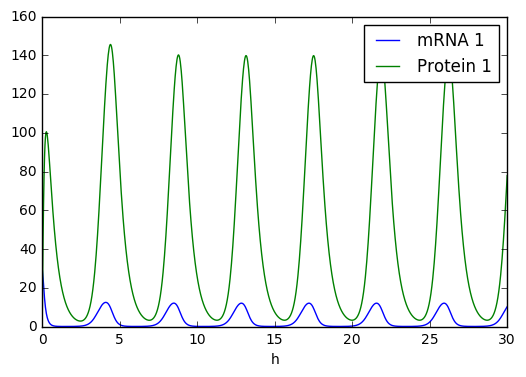

In [83]:
plt.figure()
plt.plot(t/60,y[:,0], label='mRNA 1')
plt.plot(t/60,y[:,3], label='Protein 1')
plt.xlabel('h')
plt.legend()
plt.show()

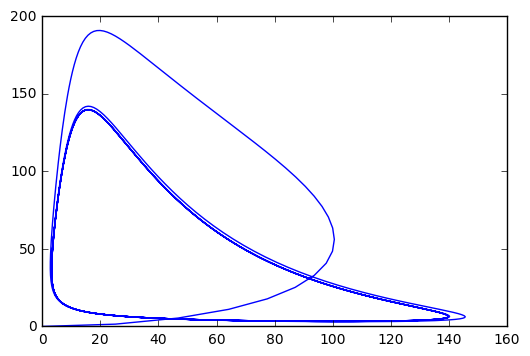

In [84]:
plt.plot(y[:,3],y[:,5]);

CRISPR repressilator

*Questions:*
- mRNA on the same Plasmid as Proteins? -> g4
- mRNA constantly produced or repressed?
- *First try: mRNA on a high copy number plasmid, not repressed*


$m$: sgRNA

$d$: dCas9

$p_3$: dCas9+mRNA complex


<font color='red'> --> what about degradation of the complex?</font>


$$ \dot r_i = -(a_i + \mu) r_i + \beta_i g_1 \frac{K_{i-1}^{\nu_i}}{K_{i-1}^{\nu_i} + p_{i-1}^{\nu_i}} $$

$$ \dot p_i = -(b_i + \mu) p_i + c_i r_i $$

$$ \dot p_3 = k d s $$

$$ \dot d = -(b_3 + \mu) d + c_3 r_3 $$

$$ \dot s = -(a_4 + \mu) s + \beta_4 g_2 $$

In [85]:
def CRISPR_repressilator(y, t, a, b, beta, c, K, nu, g, mu, k):
    # y = array([mRNA1, mRNA2, mRNA3, protein1, protein2, protein3(dCas9+sgRNA), dCas9, sgRNA])
    dydt = np.zeros_like(y)

    #mRNA1-3
    dydt[0:3] = -(a[0:3] + mu)*y[0:3] + beta[0:3]*g[0]/(1+np.power(np.roll(y[3:6],1)/np.roll(K,1),nu))
    #protein1-2
    dydt[3:5] = -(b[0:2] + mu)*y[3:5] + c[0:2]*y[0:2]
    #protein3(dCas9+sgRNA)
    dydt[5] = -(b[3] + mu)*y[5] + k*y[6]*y[7]
    #dCas9
    dydt[6] = -(b[2] + mu)*y[6] + c[2]*y[2]
    #sgRNA
    dydt[7] = -(a[3] + mu)*y[7] + beta[3]*g[1]
    return dydt

In [86]:
# Degradation rate of mRNAs (1/min)
a = np.array([np.log(2)/8.,np.log(2)/8.,np.log(2)/8.,np.log(2)/8.])
# Degradatoin rate of proteins (1/min)
b = np.array([np.log(2)/90.,np.log(2)/90.,np.log(2)/90.,np.log(2)/90.])
# Transcription rate
beta = np.array([0.4,0.4,0.4,0.4])
# Translation rate
c = np.array([0.5,0.5,0.5])
# Michaelis Menten constant
K = np.array([5,5,5])
# Hill coefficient
nu = np.array([2,2,2])
# plasmid concentration
g = [5.0,50]
# Dilution rate
T_d = 27.
mu = np.log(2)/T_d
# Association rate
k = 0.5

In [87]:
y0 = np.array([30,0,0,0,0,0,0,0])

t = np.linspace(0,30*60,1001) # simulate 30h
y = odeint(CRISPR_repressilator, y0, t, args=(a, b, beta, c, K, nu, g, mu, k))

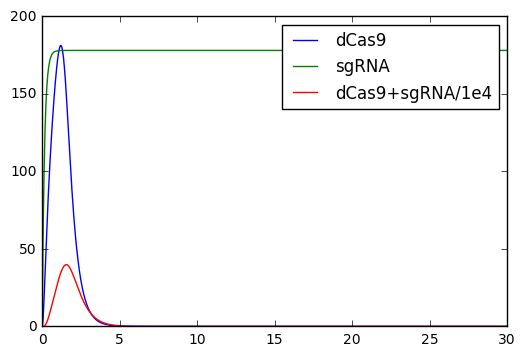

In [88]:
plt.plot(t/60,y[:,6], label='dCas9')
plt.plot(t/60,y[:,7], label='sgRNA')
plt.plot(t/60,y[:,5]/1e4, label='dCas9+sgRNA/1e4')
plt.legend();

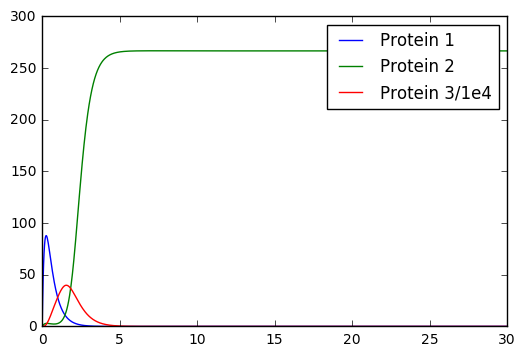

In [89]:
plt.plot(t/60,y[:,3], label='Protein 1')
plt.plot(t/60,y[:,4], label='Protein 2')
plt.plot(t/60,y[:,5]/1e4, label='Protein 3/1e4')
plt.legend();

Variation: sgRNA also repressed like dCas9

$$ \dot s = -(a_4 + \mu) s + \beta_4 g_4 \frac{K_{2}^{\nu_3}}{K_{2}^{\nu_3} + p_{2}^{\nu_3}}$$

In [90]:
def CRISPR_repressilator2(y, t, a, b, beta, c, K, nu, g, mu, k):
    # y = array([mRNA1, mRNA2, mRNA3, protein1, protein2, protein3(dCas9+sgRNA), dCas9, sgRNA])
    dydt = np.zeros_like(y)

    #mRNA1-3
    dydt[0:3] = -(a[0:3] + mu)*y[0:3] + beta*g[0:3]/(1+np.power(np.roll(y[3:6],1)/np.roll(K,1),nu))
    #protein1-2
    dydt[3:5] = -(b[0:2] + mu)*y[3:5] + c[0:2]*y[0:2]
    #protein3(dCas9+sgRNA)
    dydt[5] = -(b[3] + mu)*y[5] + k*y[6]*y[7]
    #dCas9
    dydt[6] = -(b[2] + mu)*y[6] + c[2]*y[2]
    #sgRNA
    dydt[7] = -(a[3] + mu)*y[7] + beta*g[3]/(1+np.power(y[4]/K[1],nu[2]))
    return dydt

In [91]:
# Degradation rate of mRNAs (1/min)
a = np.array([np.log(2)/8.,np.log(2)/8.,np.log(2)/8.,np.log(2)/8.])
# Degradatoin rate of proteins (1/min)
b = np.array([np.log(2)/90.,np.log(2)/90.,np.log(2)/90.,np.log(2)/90.])
# Transcription rate
beta = 0.4
# Translation rate
c = np.array([0.5,0.5,0.5])
# Michaelis Menten constant
K = np.array([5,5,5])
# Hill coefficient
nu = np.array([2,2,2])
# plasmid concentration
g = np.array([5.,5,5,5])
# Dilution rate
T_d = 27.
mu = np.log(2)/T_d
# Association rate
k = 0.5

In [92]:
y0 = np.array([30,0,0,0,0,0,0,0])

t = np.linspace(0,30*60,1001) # simulate 30h
y = odeint(CRISPR_repressilator2, y0, t, args=(a, b, beta, c, K, nu, g, mu, k))

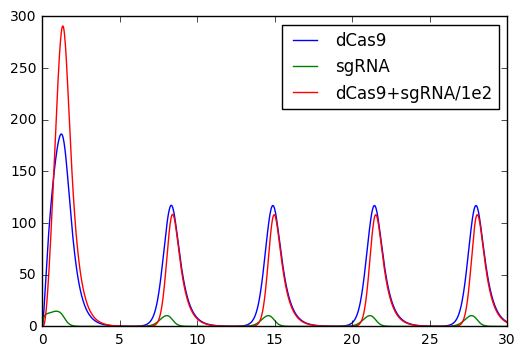

In [93]:
plt.plot(t/60,y[:,6], label='dCas9')
plt.plot(t/60,y[:,7], label='sgRNA')
plt.plot(t/60,y[:,5]/100, label='dCas9+sgRNA/1e2')
plt.legend();

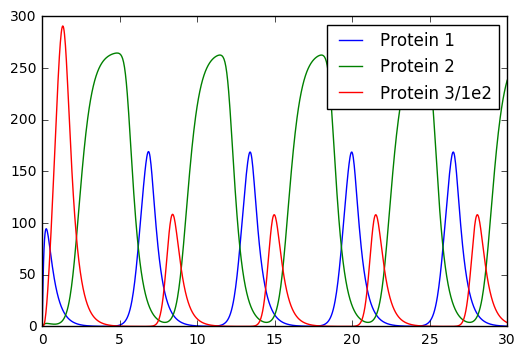

In [94]:
plt.plot(t/60,y[:,3], label='Protein 1')
plt.plot(t/60,y[:,4], label='Protein 2')
plt.plot(t/60,y[:,5]/100, label='Protein 3/1e2')
plt.legend();

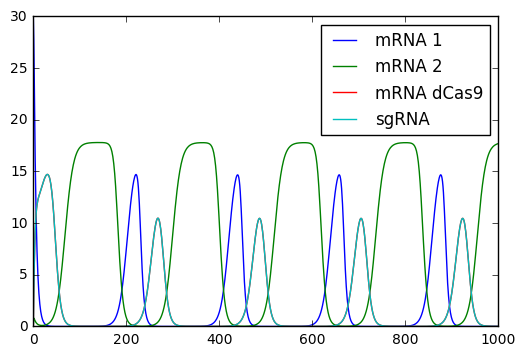

In [99]:
plt.plot(y[:,0],label='mRNA 1')
plt.plot(y[:,1],label='mRNA 2')
plt.plot(y[:,2],label='mRNA dCas9')
plt.plot(y[:,7],label='sgRNA')
plt.legend();

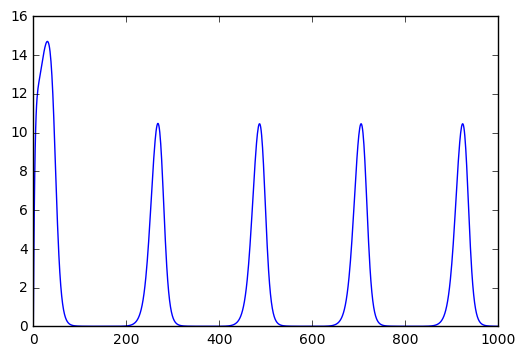

In [96]:
plt.plot(y[:,2],label='mRNA dCas9')